Import essential libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import itertools
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

Create abstract layer class

In [2]:
class Layer:
    def __init__(self):
        self.inp = None
        self.out = None

    def __call__(self, inp: np.ndarray) -> np.ndarray:
        return self.forward(inp)

    def forward(self, inp: np.ndarray) -> np.ndarray:
        raise NotImplementedError

    def backward(self, up_grad: np.ndarray) -> np.ndarray:
        raise NotImplementedError

    def step(self, lr: float) -> None:
        pass

Create linear layer class
$$\text{out} = \text{inp} \cdot \text{W} + \text{b}$$
$$\frac{\partial L}{\partial W} = \text{inp}^T \cdot \text{up\_grad} $$
$$\frac{\partial L}{\partial b} = \sum \text{1} \cdot \text{up\_grad}$$
$$\text{down\_grad} = \text{up\_grad} \cdot W^T$$


In [3]:
class Linear(Layer):
    def __init__(self, in_dim: int, out_dim: int):
        super().__init__()
        # He initialization
        self.w = 0.1 * np.random.randn(in_dim, out_dim)
        self.b = np.zeros((1, out_dim))
        self.dw = np.zeros_like(self.w)
        self.db = np.zeros_like(self.b)
        # Velocity (Momentum buffers)
        self.vw = np.zeros_like(self.w)
        self.vb = np.zeros_like(self.b)

    def forward(self, inp: np.ndarray) -> np.ndarray:
        self.inp = inp
        self.out = np.dot(inp, self.w) + self.b
        return self.out

    def backward(self, up_grad: np.ndarray) -> np.ndarray:
        # Weights & Biases gradient
        self.dw = np.dot(self.inp.T, up_grad)
        self.db = np.sum(up_grad, axis=0, keepdims=True)

        # Downstream gradient
        down_grad = np.dot(up_grad, self.w.T)
        return down_grad

    def step(self, lr: float, momentum: float) -> None:
        self.vw = momentum * self.vw - lr * self.dw
        self.vb = momentum * self.vb - lr * self.db
        
        self.w += self.vw
        self.b += self.vb

Create tanh activation function
$$f(x) = tanh(x)$$
$$f'(x) = 1 - \tanh^2(x) = 1 - f(x)^2$$

In [4]:
class Tanh(Layer):
    def forward(self, inp: np.ndarray) -> np.ndarray:
        self.out = np.tanh(inp)
        return self.out

    def backward(self, up_grad: np.ndarray) -> np.ndarray:
        down_grad = (1 - self.out ** 2) * up_grad
        return down_grad

Create sigmoid actvation function
$$f(x) = \frac{1}{1 + e^{-x}}$$
$$f'(x) = \frac{-e^{-x}}{(1 + e^{-x})^2} = \frac{1}{1 + e^{-x}} \cdot \frac{e^{-x}}{1 + e^{-x}} = f(x) \cdot (1-f(x))$$

In [5]:
class Sigmoid(Layer):
    def forward(self, inp: np.ndarray) -> np.ndarray:
        self.out = 1 / (1 + np.exp(-inp))
        return self.out

    def backward(self, up_grad: np.ndarray) -> np.ndarray:
        down_grad = self.out * (1 - self.out) * up_grad
        return down_grad

Create abstract loss class

In [6]:
class Loss:
    def __init__(self):
        self.prediction = None
        self.target = None
        self.loss = None

    def __call__(self, prediction: np.ndarray, target: np.ndarray) -> float:
        return self.forward(prediction, target)

    def forward(self, prediction: np.ndarray, target: np.ndarray) -> float:
        raise NotImplementedError

    def backward(self) -> np.ndarray:
        raise NotImplementedError

Create Mean Squared Error (MSE) Loss
$$L = \frac{1}{N} \sum_{i} (p_i - y_i)^2$$
$$\frac{\partial L}{\partial p_i} = \frac{2}{N} (p_i - y_i)$$

In [7]:
class MeanSquaredError(Loss):
    def forward(self, prediction: np.ndarray, target: np.ndarray) -> float:
        self.prediction = prediction
        self.target = target
        
        self.loss = np.mean((prediction - target) ** 2)
        return self.loss

    def backward(self) -> np.ndarray:
        grad = 2 * (self.prediction - self.target) / self.target.size
        return grad

Generate the Two-Moon dataset

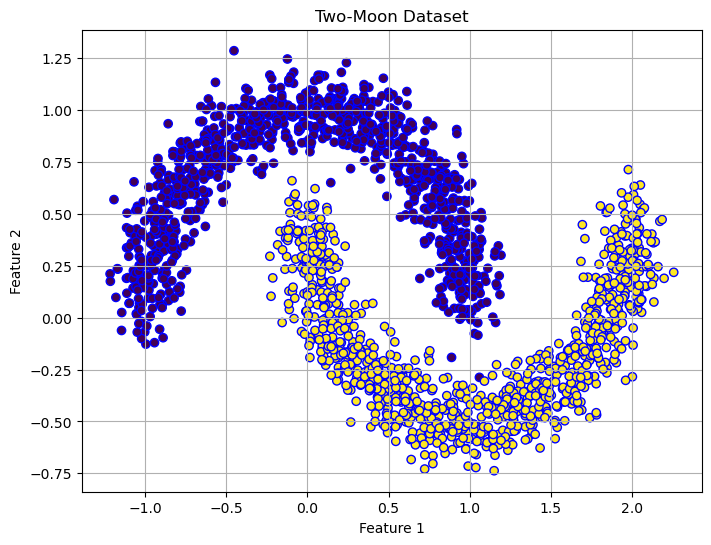

In [8]:
X, y = make_moons(n_samples=2000, noise=0.1, random_state=42)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='b')
plt.title("Two-Moon Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()

Split data into train & test subsets

In [9]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7, random_state=10)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=10)

# Reshape y arrays to (n_samples, 1)
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Check the shapes
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1400, 2), (1400, 1), (200, 2), (200, 1), (400, 2), (400, 1))

Construct MLP class 

In [10]:
class MLP:
    def __init__(self, layers: list[Layer], loss_fn: Loss, lr: float, momentum: float) -> None:
        self.layers = layers
        self.loss_fn = loss_fn
        self.lr = lr
        self.momentum = momentum

    def __call__(self, inp: np.ndarray) -> np.ndarray:
        return self.forward(inp)

    def forward(self, inp: np.ndarray) -> np.ndarray:
        # Pass input through layers sequentially
        for layer in self.layers:
            inp = layer.forward(inp)
        return inp

    def loss(self, prediction: np.ndarray, target: np.ndarray) -> float:
        return self.loss_fn(prediction, target)

    def backward(self) -> None:
        # Propagating the gradient backwards through the layers
        up_grad = self.loss_fn.backward()
        for layer in reversed(self.layers):
            up_grad = layer.backward(up_grad)

    def update(self) -> None:
        # Update each layer's parameters
        for layer in self.layers:
            try:
                layer.step(self.lr, self.momentum)
            except TypeError:
                # fallback in case layer.step doesn't accept momentum
                layer.step(self.lr)

    def train(self, X_train: np.ndarray, y_train: np.ndarray, 
              X_val: np.ndarray, y_val: np.ndarray, epochs: int, 
              batch_size: int, patience: int = 5) -> np.ndarray:
        # Train dataset over a number of epochs
        train_losses = np.empty(epochs)
        val_losses = np.empty(epochs)
        
        # Save best weights and biases
        best_weights = [np.copy(layer.w) if hasattr(layer, 'w') else None for layer in self.layers]
        best_biases  = [np.copy(layer.b) if hasattr(layer, 'b') else None for layer in self.layers]
        patience_counter = 0
        
        for epoch in (pbar := trange(epochs)):
            running_loss = 0.0
            for i in range(0, len(X_train), batch_size):
                X_batch = X_train[i:i + batch_size]
                y_batch = y_train[i:i + batch_size]
                
                prediction = self.forward(X_batch)
                running_loss += self.loss(prediction, y_batch) * batch_size
                
                self.backward()
                self.update()

            # Normalize running loss by total number of samples
            running_loss /= len(X_train)
            pbar.set_description(f"Loss: {running_loss:.3f}")
            train_losses[epoch] = running_loss
            
            val_pred = self.forward(X_val)
            val_loss = self.loss(val_pred, y_val)
            val_losses[epoch] = val_loss
            
            # Early stopping logic
            if patience:
                if val_losses[epoch] < val_losses[epoch - 1] - 1e-5:
                    patience_counter = 0
                    best_weights = [np.copy(layer.w) if hasattr(layer, 'w') else None for layer in self.layers]
                    best_biases  = [np.copy(layer.b) if hasattr(layer, 'b') else None for layer in self.layers]
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print(f"\nEarly stopping at epoch {epoch}.")
                        # Restore weights & biases
                        for layer, best_w, best_b in zip(self.layers, best_weights, best_biases):
                            if hasattr(layer, 'w'):
                                layer.w = best_w
                            if hasattr(layer, 'b'):
                                layer.b = best_b
                        
                        return train_losses[:epoch], val_losses[:epoch]
            
        return train_losses, val_losses


<class '__main__.Tanh'> <class '__main__.MeanSquaredError'> 0.0 25


Loss: 0.093:   3%|▎         | 14/500 [00:00<00:04, 116.62it/s]


Early stopping at epoch 14.


<class '__main__.Tanh'> <class '__main__.MeanSquaredError'> 0.0 1


Loss: 0.005:  44%|████▍     | 220/500 [00:23<00:30,  9.28it/s]



Early stopping at epoch 220.
<class '__main__.Tanh'> <class '__main__.MeanSquaredError'> 0.001 25


Loss: 0.094:   3%|▎         | 15/500 [00:00<00:03, 130.70it/s]



Early stopping at epoch 15.
<class '__main__.Tanh'> <class '__main__.MeanSquaredError'> 0.001 1


Loss: 0.008:  38%|███▊      | 188/500 [00:19<00:33,  9.41it/s]



Early stopping at epoch 188.
<class '__main__.Sigmoid'> <class '__main__.MeanSquaredError'> 0.0 25


Loss: 0.081:  62%|██████▏   | 311/500 [00:02<00:01, 103.72it/s]



Early stopping at epoch 311.
<class '__main__.Sigmoid'> <class '__main__.MeanSquaredError'> 0.0 1


Loss: 0.081:   6%|▌         | 29/500 [00:03<00:56,  8.36it/s]



Early stopping at epoch 29.
<class '__main__.Sigmoid'> <class '__main__.MeanSquaredError'> 0.001 25


Loss: 0.081:  65%|██████▍   | 324/500 [00:02<00:01, 113.47it/s]



Early stopping at epoch 324.
<class '__main__.Sigmoid'> <class '__main__.MeanSquaredError'> 0.001 1


Loss: 0.081:   6%|▌         | 29/500 [00:04<01:05,  7.20it/s]



Early stopping at epoch 29.


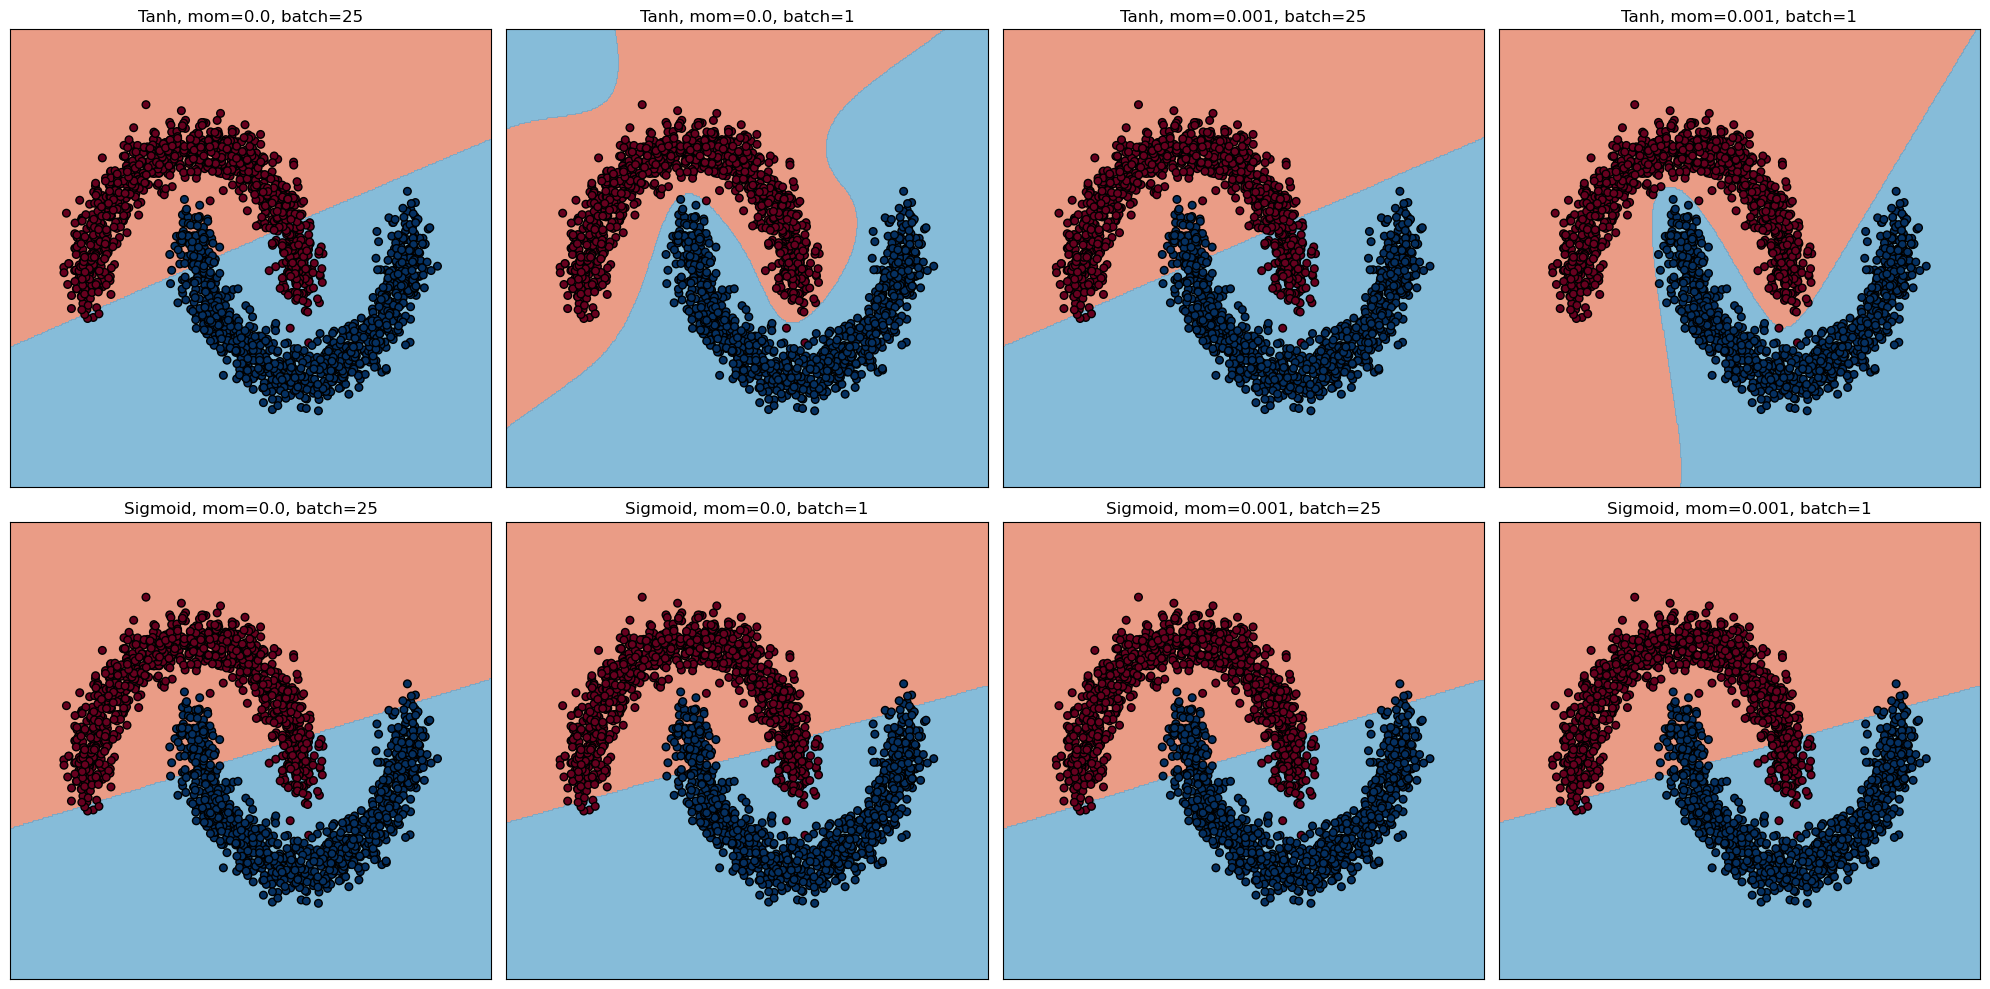

In [11]:
grid = {
    'activation': [Tanh, Sigmoid],
    'loss_fn': [MeanSquaredError],
    'momentum': [0.0, 0.001],
    'batch_size': [25, 1]
}

def plot_decision_boundary(model, X, y, ax, title):
    h = 0.01
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.forward(grid)
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z > 0.5, alpha=0.8, cmap=plt.cm.RdBu)
    # ax.contourf(xx, yy, Z, levels=20, cmap=plt.cm.RdBu, alpha=0.6)

    ax.scatter(X[:, 0], X[:, 1], c=y[:, 0], cmap=plt.cm.RdBu, edgecolors='k', marker='o', s=30)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

# Training and plotting
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, (activation, loss_fn, momentum, batch_size) in enumerate(
    itertools.product(grid['activation'], grid['loss_fn'], grid['momentum'], grid['batch_size'])):
    print(activation, loss_fn, momentum, batch_size)
    
    # Build model
    layers=[
        Linear(2, 50),
        activation(),
        Linear(50, 1),
        activation(),
    ]
    model = MLP(layers=layers, loss_fn=loss_fn(), lr=0.02, momentum=momentum)

    # Train model
    train_losses, val_losses = model.train(X_train=X_train, y_train=y_train,
                                           X_val=X_val, y_val=y_val, epochs=500,
                                           batch_size=batch_size, patience=5)

    # Plot
    ax = axes[i // 4, i % 4]
    title = f"{activation.__name__}, mom={momentum}, batch={batch_size}"
    plot_decision_boundary(model, X, y.reshape(-1, 1), ax, title)

plt.tight_layout()
plt.show()